# Fitting Yield Curves: Parametric vs. Machine Learning

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
# Loading the necessary data files
treasury_panel = pd.read_excel('../data/treasury_panel_weekly.xlsx')
gsw_yields = pd.read_excel('../data/gsw_yields.xlsx')

# Define column name constants for the dataframes
PANEL_DATE_COL = "quote date"
PANEL_TTM_COL = "ttm"
PANEL_YTM_COL = "ytm"
PANEL_CPN_COL = "cpn rate"

# Convert date columns in both dataframes to datetime objects
treasury_panel[PANEL_DATE_COL] = pd.to_datetime(treasury_panel[PANEL_DATE_COL])
gsw_yields["Date"] = pd.to_datetime(gsw_yields["Date"])

## Question 1: Nelson-Siegel Baseline
Establish the Nelson-Siegel model as a baseline for comparison.

### Question 1(a): Nelson-Siegel Parameter Estimation

We fit the Nelson-Siegel model to a single cross-section by minimizing the sum of squared yield errors. The NS yield curve is defined as:

$$r(\tau) = \beta_0 + \beta_1 \frac{1-e^{-\tau/\lambda}}{\tau/\lambda} + \beta_2 \left(\frac{1-e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}\right)$$

where $\beta_0$ corresponds to level, $\beta_1$ to slope, $\beta_2$ to curvature, and $\lambda$ controls the decay rate.

In [3]:
def ns_loadings(tau: np.ndarray, lam: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute Nelson-Siegel factor loadings.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    lam : float
        Decay parameter (lambda)
        
    Returns:
    --------
    L0, L1, L2 : tuple of arrays
        Factor loadings for level, slope, and curvature
    """
    tau = np.asarray(tau, dtype=float)
    lam = float(lam)
    
    x = tau / lam
    
    # Stable evaluation for small x to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        L1 = np.where(x == 0.0, 1.0, (1.0 - np.exp(-x)) / x)
    
    L2 = L1 - np.exp(-x)
    L0 = np.ones_like(tau)
    
    return L0, L1, L2


def ns_yield(tau: np.ndarray, beta0: float, beta1: float, beta2: float, lam: float) -> np.ndarray:
    """
    Calculate Nelson-Siegel yields for given maturities.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    beta0, beta1, beta2 : float
        NS parameters
    lam : float
        Decay parameter
        
    Returns:
    --------
    yields : array
        Predicted yields
    """
    L0, L1, L2 = ns_loadings(tau, lam)
    return beta0 * L0 + beta1 * L1 + beta2 * L2


def rmse_bps(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate RMSE in basis points.
    
    Parameters:
    -----------
    y_true, y_pred : array-like
        True and predicted yields (in decimal form)
        
    Returns:
    --------
    rmse : float
        Root mean squared error in basis points
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)) * 1e4)


@dataclass(frozen=True)
class NSFitResult:
    """Container for Nelson-Siegel fitting results."""
    beta0: float
    beta1: float
    beta2: float
    lam: float
    rmse_bps: float
    success: bool
    message: str


def fit_ns_yields_sse(
    tau: np.ndarray,
    y: np.ndarray,
    x0: Optional[np.ndarray] = None,
    bounds: Tuple[np.ndarray, np.ndarray] = (
        np.array([-0.10, -0.50, -0.50, 0.05]),
        np.array([0.20, 0.50, 0.50, 10.0])
    ),
    method: str = "L-BFGS-B",
) -> NSFitResult:
    """
    Fit Nelson-Siegel parameters by minimizing sum of squared yield errors.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    y : array-like
        Observed yields (decimal)
    x0 : array-like, optional
        Initial parameter guess [beta0, beta1, beta2, lambda]
    bounds : tuple of arrays
        Lower and upper bounds for parameters
    method : str
        Optimization method
        
    Returns:
    --------
    result : NSFitResult
        Fitted parameters and diagnostics
    """
    tau = np.asarray(tau, dtype=float)
    y = np.asarray(y, dtype=float)
    
    # Remove invalid observations
    mask = np.isfinite(tau) & np.isfinite(y) & (tau > 0)
    tau, y = tau[mask], y[mask]
    
    if len(tau) == 0:
        raise ValueError("No valid observations after filtering")
    
    # Generate initial guess if not provided
    if x0 is None:
        # Use market-informed initialization
        long_mask = tau >= np.quantile(tau, 0.8)
        short_mask = tau <= np.quantile(tau, 0.2)
        
        beta0_0 = float(np.median(y[long_mask])) if long_mask.any() else float(np.median(y))
        beta1_0 = float(np.median(y[short_mask]) - beta0_0) if short_mask.any() else 0.0
        beta2_0 = 0.0
        lam_0 = 2.0
        
        x0 = np.array([beta0_0, beta1_0, beta2_0, lam_0], dtype=float)
    
    lo, hi = bounds
    
    # Objective function: sum of squared errors
    def obj(theta: np.ndarray) -> float:
        b0, b1, b2, lam = theta
        yhat = ns_yield(tau, b0, b1, b2, lam)
        err = y - yhat
        return float(np.dot(err, err))
    
    # Optimize
    res = minimize(obj, x0=x0, method=method, bounds=list(zip(lo, hi)))
    
    b0, b1, b2, lam = res.x
    yhat = ns_yield(tau, b0, b1, b2, lam)
    
    return NSFitResult(
        beta0=float(b0),
        beta1=float(b1),
        beta2=float(b2),
        lam=float(lam),
        rmse_bps=rmse_bps(y, yhat),
        success=bool(res.success),
        message=str(res.message),
    )

In [4]:
# Fit the Nelson-Siegel model to the most recent cross-section in the panel
one_date = treasury_panel[PANEL_DATE_COL].max()
cs = treasury_panel.loc[treasury_panel[PANEL_DATE_COL] == one_date].copy()

tau_cs = cs[PANEL_TTM_COL].to_numpy()
y_cs = cs[PANEL_YTM_COL].to_numpy()

# Fit the model
ns1 = fit_ns_yields_sse(tau_cs, y_cs)


# Display the results of the fit
ns1_df = pd.DataFrame({
    'Parameter': [
        "Cross-section date",
        "β₀ (level)",
        "β₁ (slope)",
        "β₂ (curvature)",
        "λ  (decay)",
        "In-sample RMSE (bps)"
    ],
    'Value': [
        one_date.date(),
        f"{ns1.beta0:.6f}",
        f"{ns1.beta1:.6f}",
        f"{ns1.beta2:.6f}",
        f"{ns1.lam:.6f}",
        f"{ns1.rmse_bps:.2f}"
    ]
})

display(ns1_df)

,Parameter,Value
0,Cross-section date,2025-12-31
1,β₀ (level),0.055289
2,β₁ (slope),-0.020012
3,β₂ (curvature),-0.026093
4,λ (decay),3.185387
5,In-sample RMSE (bps),10.11


### Question 1(b): Plot fitted curve and identify systematic errors

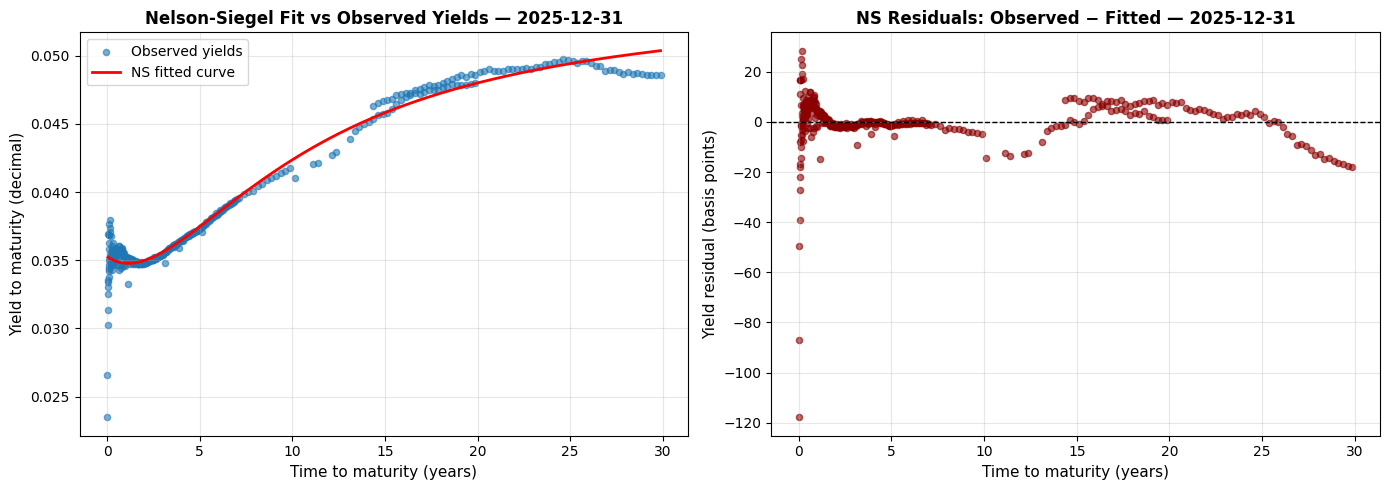

,mean,std,min,max
segment,,,,
Very Short (0-2y),0.674186,14.753580,-117.846379,28.395444
Short (2-5y),-1.116765,1.158164,-9.150484,0.484769
Medium (5-15y),-1.845643,4.410305,-14.449517,9.485271
Long (15-25y),5.105530,2.672297,-0.734536,9.660849
Longest (25y+),-9.481174,6.694938,-18.039458,1.963028


In [5]:
# Plotting observed yields versus fitted yields using the Nelson-Siegel model
tau_grid = np.linspace(max(0.05, np.nanmin(tau_cs)), np.nanmax(tau_cs), 300)
y_grid = ns_yield(tau_grid, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Fitted curve vs observed
ax1.scatter(tau_cs, y_cs, s=20, alpha=0.6, label='Observed yields')
ax1.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax1.set_title(f'Nelson-Siegel Fit vs Observed Yields — {one_date.date()}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: Residuals by maturity
resid = y_cs - ns_yield(tau_cs, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)
ax2.scatter(tau_cs, resid * 1e4, s=20, alpha=0.6, color='darkred')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('Yield residual (basis points)', fontsize=11)
ax2.set_title(f'NS Residuals: Observed − Fitted — {one_date.date()}', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary of residuals by different maturity regions
residuals_df = pd.DataFrame({
    'ttm': tau_cs,
    'residual_bps': resid * 1e4
})

# Define maturity buckets: 0-2, 2-5, 5-15, 15-25, 25+
bucket_edges = [0, 2, 5, 15, 25, float('inf')]
bucket_labels = [
    'Very Short (0-2y)',
    'Short (2-5y)',
    'Medium (5-15y)',
    'Long (15-25y)',
    'Longest (25y+)'
]
residuals_df['segment'] = pd.cut(
    residuals_df['ttm'],
    bins=bucket_edges,
    labels=bucket_labels,
    right=False,  # left-inclusive: ttm >= left, ttm < right
    include_lowest=True
)

stats_df = residuals_df.groupby('segment')['residual_bps'].describe()[['mean', 'std', 'min', 'max']]
stats_df = stats_df.reset_index()
stats_df = stats_df.set_index('segment')
stats_df = stats_df.style.set_caption("Residual statistics by different maturity regions")
display(stats_df)

#### Interpretation of Nelson-Siegel Residuals

The Nelson-Siegel model offers a smooth approximation of the yield curve, but analysis of the residuals reveals clear systematic patterns. The model alternates between over- and under-predicting yields across different maturity ranges:

**Very Short Maturity (0–2y):**
- The mean residual is slightly positive (0.674 bps), but this is misleading given the high volatility. The standard deviation is large (14.75 bps), and the minimum residual is extremely negative (-117.8 bps). This indicates the model tends to over-predict yields for short-term maturities.

**Short to Medium "Belly" (2–15y):**
- In this region, the model consistently over-predicts yields, as shown by negative mean residuals (from -1.11 bps for the 2–5 year segment to -1.84 bps for the 5–15 year segment). The low standard deviation in the 2–5 year bucket (1.15 bps) indicates this over-prediction is systematic: the model's curve sits persistently above actual market yields in this "belly" range.

**Long Maturity (15–25y):**
- The mean residual becomes positive (5.10 bps), signaling that the model now under-predicts yields in this sector. This may reflect added local steepness ("hump") in the market curve not fully captured by the NS model's single curvature parameter (β₂).

**Longest Maturity (25y+):**
- In the ultra-long segment, residuals turn negative again (mean -9.48 bps). Thus, the model over-predicts yields at the longest maturities, failing to flatten as rapidly as observed in market data.

**Systematic vs. Idiosyncratic Errors:**

- *Systematic Errors:* The consistent switching of residuals between negative and positive across the 2–5y, 15–25y, and 25y+ maturities illustrates a structural limitation of the Nelson-Siegel functional form.

- *Idiosyncratic Errors:* The wide dispersion in the 0–2y segment likely results from bond-specific effects (such as the "on-the-run" premium or year-end liquidity factors) that the NS model does not capture.

### Question 1(c): Verify discount factors are positive and decreasing

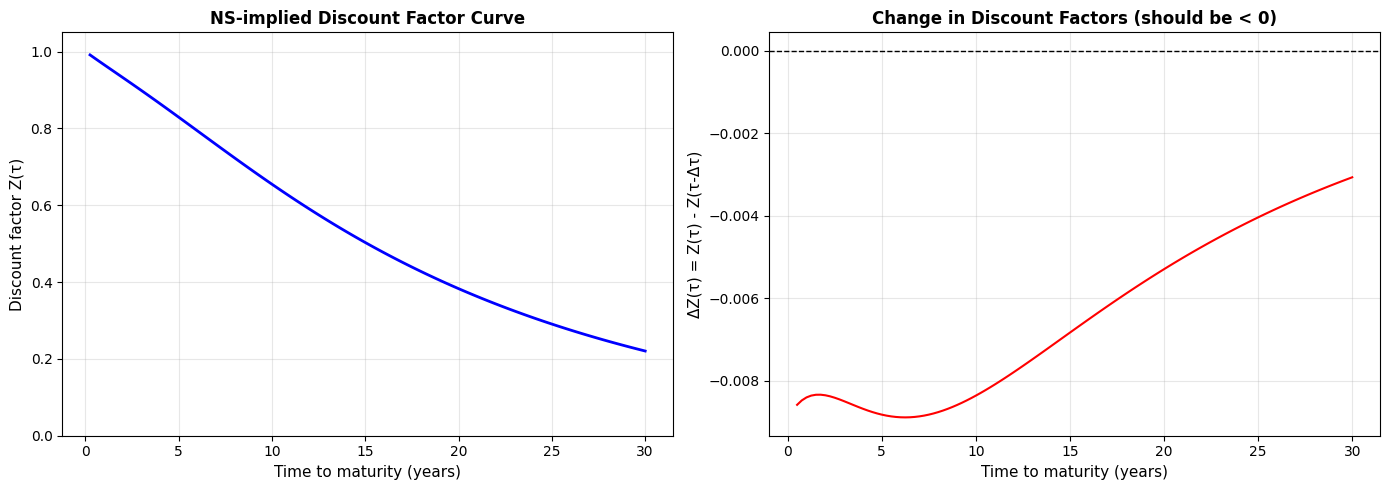

,Check,Result
0,All discount factors positive,True
1,All discount factors decreasing,True
2,Overall verdict,✓


In [6]:
def spot_to_discount(tau: np.ndarray, r: np.ndarray) -> np.ndarray:
    """
    Convert spot (zero-coupon) yields to discount factors.
    
    Z(τ) = exp(-r(τ) × τ)
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    r : array-like
        Spot yields (decimal, continuously compounded)
        
    Returns:
    --------
    Z : array
        Discount factors
    """
    tau = np.asarray(tau, dtype=float)
    r = np.asarray(r, dtype=float)
    return np.exp(-r * tau)


# Generate discount factors on a grid of maturities for further analysis and plotting
tau_dense = np.linspace(0.25, 30, 120) 
r_dense = ns_yield(tau_dense, ns1.beta0, ns1.beta1, ns1.beta2, ns1.lam)
Z_dense = spot_to_discount(tau_dense, r_dense)

# Check discount factors for financial sanity:
# - Must be strictly positive
# - Must be decreasing with maturity
all_positive = np.all(Z_dense > 0)
all_decreasing = np.all(np.diff(Z_dense) < 0)

df_sanity = pd.DataFrame({
    "Check": [
        "All discount factors positive",
        "All discount factors decreasing",
        "Overall verdict"
    ],
    "Result": [
        all_positive,
        all_decreasing,
        "✓" if all_positive and all_decreasing else "✗"
    ]
})

# Plot discount factor curve and its first differences to visualize behavior and monotonicity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Discount factor curve
ax1.plot(tau_dense, Z_dense, 'b-', linewidth=2)
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Discount factor Z(τ)', fontsize=11)
ax1.set_title('NS-implied Discount Factor Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Right: First differences to check monotonicity
dZ = np.diff(Z_dense)
ax2.plot(tau_dense[1:], dZ, 'r-', linewidth=1.5)
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('ΔZ(τ) = Z(τ) - Z(τ-Δτ)', fontsize=11)
ax2.set_title('Change in Discount Factors (should be < 0)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display the verification results
display(df_sanity)

## Question 2: Hold-Out Validation Framework
Implement cross-validation to measure true out-of-sample performance.

### Question 2(a): Implement train-test split with stratification

In [7]:
def stratified_train_test_split(
    df: pd.DataFrame,
    ttm_col: str,
    test_size: float = 0.2,
    random_state: int = 42,
    n_strata: int = 3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split bonds into train/test sets with stratification by maturity bucket.
    
    Ensures test set spans the entire yield curve by maintaining maturity
    distribution in both train and test sets.
    
    Parameters:
    -----------
    df : DataFrame
        Bond data for a single date
    ttm_col : str
        Column name for time to maturity
    test_size : float
        Proportion of data for test set
    random_state : int
        Random seed for reproducibility
    n_strata : int
        Number of maturity buckets for stratification
        
    Returns:
    --------
    train_df, test_df : tuple of DataFrames
        Training and test sets
    """
    df = df.copy()
    
    # Create maturity strata using quantiles
    df['_maturity_stratum'] = pd.qcut(
        df[ttm_col], 
        q=n_strata, 
        labels=False, 
        duplicates='drop'
    )
    
    # Split within each stratum
    train_indices = []
    test_indices = []
    
    for stratum in df['_maturity_stratum'].unique():
        stratum_mask = df['_maturity_stratum'] == stratum
        stratum_indices = df[stratum_mask].index.tolist()
        
        # Split this stratum
        n_test = max(1, int(len(stratum_indices) * test_size))
        np.random.seed(random_state)
        test_idx = np.random.choice(stratum_indices, size=n_test, replace=False)
        train_idx = [i for i in stratum_indices if i not in test_idx]
        
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)
    
    train_df = df.loc[train_indices].drop('_maturity_stratum', axis=1)
    test_df = df.loc[test_indices].drop('_maturity_stratum', axis=1)
    
    return train_df, test_df


# Perform stratified train-test split on a single cross-section
train_cs, test_cs = stratified_train_test_split(
    cs, 
    ttm_col=PANEL_TTM_COL,
    test_size=0.2,
    random_state=42,
    n_strata=3
)

# Summary DataFrames of stratified train-test split
count_data = {
    "Metric": [
        "Total bonds",
        "Training bonds",
        "Test bonds"
    ],
    "Value": [
        len(cs),
        f"{len(train_cs)} ({100*len(train_cs)/len(cs):.1f}%)",
        f"{len(test_cs)} ({100*len(test_cs)/len(cs):.1f}%)"
    ]
}

count_summary_df = pd.DataFrame(count_data)
count_summary_df = count_summary_df.set_index("Metric")
count_summary_df = count_summary_df.style.set_caption(f"Bond counts for {one_date.date()}")

# TTM (maturity) distribution summary
dist_data = {
    "Set": ["Train", "Test"],
    "Min (y)": [
        f"{train_cs[PANEL_TTM_COL].min():.2f}",
        f"{test_cs[PANEL_TTM_COL].min():.2f}",
    ],
    "Median (y)": [
        f"{train_cs[PANEL_TTM_COL].median():.2f}",
        f"{test_cs[PANEL_TTM_COL].median():.2f}",
    ],
    "Max (y)": [
        f"{train_cs[PANEL_TTM_COL].max():.2f}",
        f"{test_cs[PANEL_TTM_COL].max():.2f}",
    ]
}

dist_summary_df = pd.DataFrame(dist_data)
dist_summary_df = dist_summary_df.set_index("Set")
dist_summary_df = dist_summary_df.style.set_caption(f"Maturity distribution for {one_date.date()}")

display(count_summary_df, dist_summary_df)

,Value
Metric,
Total bonds,401
Training bonds,322 (80.3%)
Test bonds,79 (19.7%)


,Min (y),Median (y),Max (y)
Set,,,
Train,0.02,3.04,29.87
Test,0.04,2.83,28.37


### Question 2(b): Fit on training set, evaluate on test set

In [19]:
# Fit NS on training data only and evaluate on test set
tau_train = train_cs[PANEL_TTM_COL].to_numpy()
y_train = train_cs[PANEL_YTM_COL].to_numpy()

tau_test = test_cs[PANEL_TTM_COL].to_numpy()
y_test = test_cs[PANEL_YTM_COL].to_numpy()

# Fit model
ns_train = fit_ns_yields_sse(tau_train, y_train)

# Predict on test set
y_test_pred = ns_yield(tau_test, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)
test_rmse = rmse_bps(y_test, y_test_pred)

# Calculate overfitting ratio
overfit_ratio = test_rmse / ns_train.rmse_bps

# Display results
results_data = {
    "Metric": ["Training RMSE (bps)", "Test RMSE (bps)", "Test/Train ratio"],
    "Value": [
        f"{ns_train.rmse_bps:.2f}",
        f"{test_rmse:.2f}",
        f"{overfit_ratio:.3f}"
    ]
}
results_df = pd.DataFrame(results_data).set_index("Metric")
results_styled = results_df.style.set_caption(f"Hold-out validation results for {one_date.date()}")
display(results_styled)

,Value
Metric,
Training RMSE (bps),10.70
Test RMSE (bps),7.21
Test/Train ratio,0.674


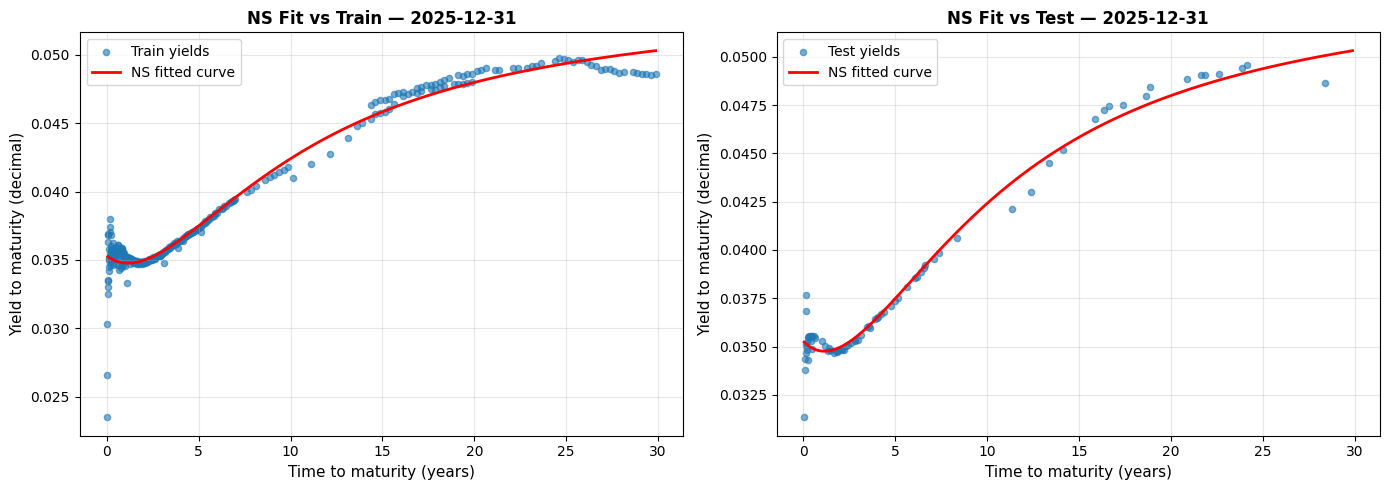

In [ ]:
# Plot fitted NS curve vs train and vs test
tau_min = max(0.05, min(np.nanmin(tau_train), np.nanmin(tau_test)))
tau_max = max(np.nanmax(tau_train), np.nanmax(tau_test))
tau_grid = np.linspace(tau_min, tau_max, 300)
y_grid = ns_yield(tau_grid, ns_train.beta0, ns_train.beta1, ns_train.beta2, ns_train.lam)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: fitted curve vs training yields
ax1.scatter(tau_train, y_train, s=20, alpha=0.6, label='Train yields')
ax1.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax1.set_xlabel('Time to maturity (years)', fontsize=11)
ax1.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax1.set_title(f'NS Fit vs Train — {one_date.date()}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: same fitted curve vs test yields
ax2.scatter(tau_test, y_test, s=20, alpha=0.6, label='Test yields')
ax2.plot(tau_grid, y_grid, 'r-', linewidth=2, label='NS fitted curve')
ax2.set_xlabel('Time to maturity (years)', fontsize=11)
ax2.set_ylabel('Yield to maturity (decimal)', fontsize=11)
ax2.set_title(f'NS Fit vs Test — {one_date.date()}', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Question 2(c): Repeat with multiple random seeds

In [9]:
# Repeat train/test split with multiple seeds
n_splits = 10
random_seeds = range(42, 42 + n_splits)

split_results = []

for seed in random_seeds:
    # Split data
    train_cs_i, test_cs_i = stratified_train_test_split(
        cs,
        ttm_col=PANEL_TTM_COL,
        test_size=0.2,
        random_state=seed,
        n_strata=3
    )
    
    # Fit on training
    tau_train_i = train_cs_i[PANEL_TTM_COL].to_numpy()
    y_train_i = train_cs_i[PANEL_YTM_COL].to_numpy()
    ns_fit_i = fit_ns_yields_sse(tau_train_i, y_train_i)
    
    # Predict on test
    tau_test_i = test_cs_i[PANEL_TTM_COL].to_numpy()
    y_test_i = test_cs_i[PANEL_YTM_COL].to_numpy()
    y_test_pred_i = ns_yield(tau_test_i, ns_fit_i.beta0, ns_fit_i.beta1, ns_fit_i.beta2, ns_fit_i.lam)
    test_rmse_i = rmse_bps(y_test_i, y_test_pred_i)
    
    split_results.append({
        'seed': seed,
        'train_rmse': ns_fit_i.rmse_bps,
        'test_rmse': test_rmse_i,
        'ratio': test_rmse_i / ns_fit_i.rmse_bps,
        'beta0': ns_fit_i.beta0,
        'beta1': ns_fit_i.beta1,
        'beta2': ns_fit_i.beta2,
        'lambda': ns_fit_i.lam
    })

split_df = pd.DataFrame(split_results)

# Display test RMSE statistics in a DataFrame with caption
rmse_stats = pd.DataFrame({
    'Statistic': ['Mean', 'Std', 'Min', 'Max', 'Median'],
    'Test RMSE (bps)': [
        split_df['test_rmse'].mean(),
        split_df['test_rmse'].std(),
        split_df['test_rmse'].min(),
        split_df['test_rmse'].max(),
        split_df['test_rmse'].median()
    ]
})

rmse_stats_styled = rmse_stats.style.set_caption(f'Nelson-Siegel Test RMSE statistics across {n_splits} random train/test splits')
display(rmse_stats_styled)

,Statistic,Test RMSE (bps)
0,Mean,9.918578
1,Std,3.482136
2,Min,5.639540
3,Max,14.779686
4,Median,8.741285


#### Is NS Performance Stable?

Yes, the performance is generally stable, but with a few important nuances:

- **Low Absolute Variation:**  
  A standard deviation of 3.48 bps is relatively small. It indicates that the model's accuracy doesn't fluctuate wildly just because different bonds were chosen for the training set.

- **Consistency of the Mean:**  
  The mean RMSE (9.92 bps) is close to the median (8.74 bps), suggesting that the distribution of errors is not heavily skewed by extreme outliers in the testing process.

- **Impact of Idiosyncratic Noise:**  
Since each split contains the same proportion of short, medium, and long-term bonds, the variation in RMSE is likely driven by idiosyncratic pricing. Specifically, the "Very Short" segment (0-2y) has a massive standard deviation of 14.75 bps and a minimum residual of -117.85 bps. If specific high-noise securities (highly illiquid off-the-run instrument) fall into the test set, they will pull the RMSE higher, even if the maturity distribution is perfectly balanced.

**Conclusion:**  
> The Nelson-Siegel model demonstrates good stability across 10 random train/test splits. With a mean test RMSE of 9.92 bps and a relatively low standard deviation of 3.48 bps. The model's predictive power is consistent across different random seed. The moderate range in RMSE suggests that the functional form for Nelson-Siegel is stable.

### Question 2(d): Time-series analysis across market regimes

In [10]:
# Select all the dates spanning different regimes
all_dates = treasury_panel[PANEL_DATE_COL].unique()
all_dates = pd.to_datetime(all_dates)
all_dates = np.sort(all_dates)

# Take every 4th week to get ~100 dates across 2018-2025
date_sample = all_dates[::4][:min(100, len(all_dates)//4)]

# Start and end dates for the analysis
start_str = pd.Timestamp(date_sample[0]).date()
end_str = pd.Timestamp(date_sample[-1]).date()

# === Fit NS with hold-out validation for each date ===
ts_results = []

for date in date_sample:
    df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == date].copy()

    if len(df_date) < 30:  # Skip dates with too few bonds
        continue

    # Train/test split
    try:
        train_df, test_df = stratified_train_test_split(
            df_date,
            ttm_col=PANEL_TTM_COL,
            test_size=0.2,
            random_state=42,
            n_strata=3
        )
    except Exception:
        continue  # Skip if stratification fails

    # Fit on training set
    tau_train = train_df[PANEL_TTM_COL].to_numpy()
    y_train = train_df[PANEL_YTM_COL].to_numpy()

    try:
        ns_fit = fit_ns_yields_sse(tau_train, y_train)
    except Exception:
        continue

    # Evaluate on test set
    tau_test = test_df[PANEL_TTM_COL].to_numpy()
    y_test = test_df[PANEL_YTM_COL].to_numpy()
    y_test_pred = ns_yield(tau_test, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam)
    test_rmse = rmse_bps(y_test, y_test_pred)

    # Calculate additional diagnostics
    curve_level = ns_fit.beta0  # Long-run level
    curve_slope = ns_fit.beta1  # Short-term component (negative = inverted)
    curve_curvature = ns_fit.beta2

    # Volatility proxy: standard deviation of yields
    yield_vol = np.std(y_train)

    # Curve shape metrics
    short_yield = np.median(y_train[tau_train <= 2]) if np.any(tau_train <= 2) else np.nan
    long_yield = np.median(y_train[tau_train >= 10]) if np.any(tau_train >= 10) else np.nan
    slope_2s10s = long_yield - short_yield if not np.isnan(long_yield) and not np.isnan(short_yield) else np.nan

    ts_results.append({
        'date': date,
        'train_rmse': ns_fit.rmse_bps,
        'test_rmse': test_rmse,
        'ratio': test_rmse / ns_fit.rmse_bps if ns_fit.rmse_bps > 0 else np.nan,
        'n_bonds': len(df_date),
        'n_train': len(train_df),
        'n_test': len(test_df),
        'beta0': ns_fit.beta0,
        'beta1': ns_fit.beta1,
        'beta2': ns_fit.beta2,
        'lambda': ns_fit.lam,
        'yield_level': curve_level,
        'yield_slope': curve_slope,
        'yield_vol': yield_vol,
        'slope_2s10s': slope_2s10s
    })

ts_df = pd.DataFrame(ts_results)

# Display summary
summary_stats = ts_df['test_rmse'].describe().to_frame().reset_index()
summary_stats.columns = ['Statistic', 'Test RMSE (bps)']
caption_text = f"Nelson-Siegel Test RMSE Statistics Across {len(ts_df)} Dates ({start_str} to {end_str})"
display(summary_stats.style.set_caption(caption_text))

,Statistic,Test RMSE (bps)
0,count,100.000000
1,mean,15.160141
2,std,14.918310
3,min,3.763350
4,25%,8.186562
5,50%,11.237994
6,75%,15.514918
7,max,98.328227


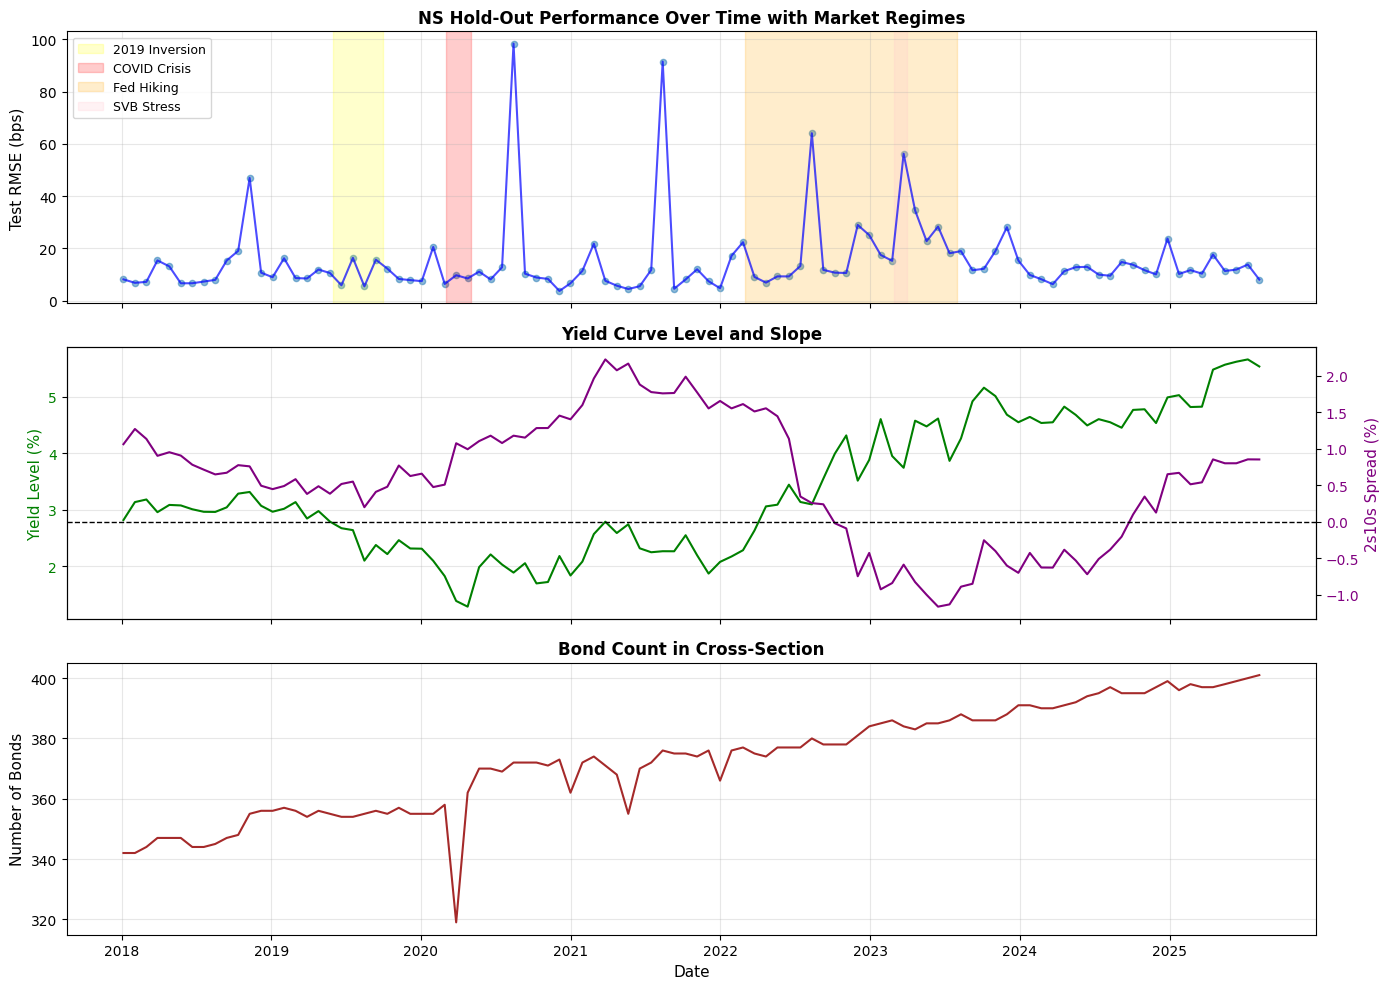

In [11]:
# Plot test RMSE over time with various regime annotations
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Test RMSE over time
ax = axes[0]
ax.plot(ts_df['date'], ts_df['test_rmse'], 'b-', linewidth=1.5, alpha=0.7)
ax.scatter(ts_df['date'], ts_df['test_rmse'], s=20, alpha=0.5)

# Add regime annotations
regime_periods = [
    ('2019-06-01', '2019-10-01', '2019 Inversion', 'yellow'),
    ('2020-03-01', '2020-05-01', 'COVID Crisis', 'red'),
    ('2022-03-01', '2023-08-01', 'Fed Hiking', 'orange'),
    ('2023-03-01', '2023-04-01', 'SVB Stress', 'pink'),
]

for start, end, label, color in regime_periods:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color, label=label)

ax.set_ylabel('Test RMSE (bps)', fontsize=11)
ax.set_title('NS Hold-Out Performance Over Time with Market Regimes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Yield level and slope
ax = axes[1]
ax.plot(ts_df['date'], ts_df['yield_level'] * 100, 'g-', linewidth=1.5, label='Level (β₀)')
ax.set_ylabel('Yield Level (%)', fontsize=11, color='g')
ax.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(ts_df['date'], ts_df['slope_2s10s'] * 100, 'purple', linewidth=1.5, label='2s10s Spread')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('2s10s Spread (%)', fontsize=11, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax.set_title('Yield Curve Level and Slope', fontsize=12, fontweight='bold')

# Panel 3: Number of bonds available
ax = axes[2]
ax.plot(ts_df['date'], ts_df['n_bonds'], 'brown', linewidth=1.5)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Number of Bonds', fontsize=11)
ax.set_title('Bond Count in Cross-Section', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Identify periods with highest fitting difficulty
# We define "hard to fit" as top quartile of test RMSE
hard_threshold = ts_df['test_rmse'].quantile(0.75)
hard_periods = ts_df[ts_df['test_rmse'] > hard_threshold].copy()

# Top 10 hardest dates DataFrame
hardest_df = hard_periods.nlargest(10, 'test_rmse')[['date', 'test_rmse', 'yield_level', 'slope_2s10s', 'yield_vol', 'n_bonds']].reset_index(drop=True)
hardest_df_styled = hardest_df.style.set_caption(
    f"Top 10 hardest periods to fit (test RMSE > {hard_threshold:.2f} bps)")

# Create summary DataFrame for characteristics
summary_data = [
    ["Average test RMSE (bps)",    f"{hard_periods['test_rmse'].mean():.2f}", f"{ts_df['test_rmse'].mean():.2f}"],
    ["Average yield volatility",   f"{hard_periods['yield_vol'].mean():.6f}", f"{ts_df['yield_vol'].mean():.6f}"],
    ["Average yield level (%)",    f"{hard_periods['yield_level'].mean()*100:.3f}", f"{ts_df['yield_level'].mean()*100:.3f}"],
    ["Average 2s10s spread (%)",  f"{hard_periods['slope_2s10s'].mean()*100:.3f}", f"{ts_df['slope_2s10s'].mean()*100:.3f}"],
    ["Average bond count",         f"{hard_periods['n_bonds'].mean():.0f}", f"{ts_df['n_bonds'].mean():.0f}"],
]
summary_df = pd.DataFrame(summary_data, columns=['Statistic', 'Hard-to-Fit Periods', 'Overall Avg'])
summary_df_styled = summary_df.style.set_caption("Characteristics of Hard-to-Fit Periods")

# Correlation analysis DataFrame
corr_vars = ['yield_level', 'yield_vol', 'slope_2s10s', 'n_bonds']
corr_results = []
for var in corr_vars:
    corr = ts_df[['test_rmse', var]].corr().iloc[0, 1]
    corr_results.append([f"Corr(test_rmse, {var})", corr])
corr_df = pd.DataFrame(corr_results, columns=["Variable", "Correlation"])
corr_df_styled = corr_df.style.set_caption("Correlation of test RMSE with Market Conditions")

# Display DataFrames
display(hardest_df_styled)
display(summary_df_styled)
display(corr_df_styled)

,date,test_rmse,yield_level,slope_2s10s,yield_vol,n_bonds
0,2020-08-14 00:00:00,98.328227,0.018899,0.011809,0.004233,372
1,2021-08-13 00:00:00,91.475644,0.022677,0.017611,0.006403,376
2,2022-08-12 00:00:00,64.081717,0.030960,0.002557,0.003287,380
3,2023-03-24 00:00:00,56.239655,0.037436,-0.005888,0.004132,384
4,2018-11-09 00:00:00,46.981227,0.033154,0.007598,0.003321,355
5,2023-04-21 00:00:00,34.559176,0.045760,-0.008278,0.004884,383
6,2022-12-02 00:00:00,28.998024,0.035157,-0.007478,0.004007,381
7,2023-06-16 00:00:00,28.386787,0.046138,-0.011651,0.005411,385
8,2023-12-01 00:00:00,28.146076,0.046821,-0.006021,0.004318,388
9,2022-12-30 00:00:00,25.125777,0.038825,-0.004282,0.003828,384


,Statistic,Hard-to-Fit Periods,Overall Avg
0,Average test RMSE (bps),31.59,15.16
1,Average yield volatility,0.004351,0.004260
2,Average yield level (%),3.549,3.351
3,Average 2s10s spread (%),0.183,0.574
4,Average bond count,376,373


,Variable,Correlation
0,"Corr(test_rmse, yield_level)",0.009837
1,"Corr(test_rmse, yield_vol)",0.027538
2,"Corr(test_rmse, slope_2s10s)",-0.117619
3,"Corr(test_rmse, n_bonds)",0.131797


#### Analysis of Nelson-Siegel Fitting Difficulty
 
The fitting difficulty of the Nelson-Siegel model varies across market regimes, as shown by comparisons between "hard-to-fit" periods and overall averages:
 
**High RMSE periods are characterized by:**
 
- **Lower Yield Spreads (Flat or Inverted Curves):**  
   The "hard-to-fit" periods exhibit a much lower average 2s10s spread (0.183%) compared to the overall average (0.574%). This demonstrates that the Nelson-Siegel functional form struggles significantly when the yield curve flattens or inverts.
 
- **Elevated Market Stress:**  
   The average test RMSE for these challenging periods is 31.59 bps, more than double the overall average of 15.16 bps.
 
#### Key Regime Observations from the Top 10 Hardest Dates
 
- **Post-Pandemic Recovery (2020-08-14):**  
   This is the most difficult period to fit, with a substantial test RMSE of 98.33 bps. Despite a relatively normal slope, high idiosyncratic volatility during the COVID-19 recovery phase likely created extreme pricing dispersions.
   
- **Post-Pandemic Inflation Repricing (2021-08-13):**  
   The second hardest date (RMSE 91.48 bps) saw the highest cross-sectional yield volatility in the top 10 (0.0064), illustrating that the rapid repricing of inflation expectations introduces noise that the smooth NS curve cannot capture.
   
- **The 2022-2023 Inversion/Hiking Cycle:**  
   Seven of the ten hardest dates occur during the aggressive Fed hiking cycle. These dates (e.g., 2023-03-24 during the SVB crisis and 2023-06-16) are characterized by negative 2s10s slopes.
   
- **Late 2018 Volatility:**  
   The inclusion of 2018-11-09 (RMSE 46.98 bps) aligns with the period of quantitative tightening and growth concerns preceding the 2019 Fed pivot.
 
- **Bond Availability:** 
   Interestingly, the "hard-to-fit" periods have a slightly higher average bond count (376) than the overall average (373). This suggests that fitting difficulty is driven more by market volatility and curve shape than by a lack of data points.

## Question 3: ML Alternatives
Compare machine learning methods to Nelson-Siegel using the same out-of-sample framework.

In [23]:
# ML Feature Engineering
def create_ml_features(tau: np.ndarray, cpn: Optional[np.ndarray] = None, 
                       degree: int = 3, include_ns_features: bool = True) -> np.ndarray:
    """
    Create feature matrix for ML models.
    
    Features include:
    - Polynomial terms of maturity (tau, tau^2, ..., tau^degree)
    - NS-like basis functions (optional)
    - Coupon rate (optional)
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity in years
    cpn : array-like, optional
        Coupon rates (decimal)
    degree : int
        Degree of polynomial features
    include_ns_features : bool
        Whether to include NS-like loadings as features
        
    Returns:
    --------
    X : array
        Feature matrix (n_bonds, n_features)
    """
    tau = np.asarray(tau, dtype=float).reshape(-1, 1)
    
    # Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(tau)
    
    features = [X_poly]
    
    # NS-like basis functions (with fixed lambda)
    if include_ns_features:
        lam = 2.0  # Fixed decay parameter
        L0, L1, L2 = ns_loadings(tau.flatten(), lam)
        X_ns = np.column_stack([L0, L1, L2])
        features.append(X_ns)
    
    # Coupon effect
    if cpn is not None:
        cpn = np.asarray(cpn, dtype=float).reshape(-1, 1)
        features.append(cpn)
    
    X = np.hstack(features)
    
    return X


# === ML Model Fitting Functions ===
@dataclass(frozen=True)
class MLFitResult:
    """Container for ML model fitting results."""
    model_name: str
    train_rmse: float
    test_rmse: float
    ratio: float
    model: object # Fitted sklearn model
    params: Dict  # Hyperparameters used


def fit_ridge_cv(X_train: np.ndarray, y_train: np.ndarray, 
                 X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Ridge regression with cross-validated regularization parameter.
    
    Ridge adds L2 penalty to prevent overfitting in high-dimensional feature space.
    """
    # Grid search for optimal alpha
    alphas = np.logspace(-4, 4, 50)
    ridge = Ridge()
    
    grid_search = GridSearchCV(
        ridge, 
        param_grid={'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Ridge',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params={'alpha': grid_search.best_params_['alpha']}
    )


def fit_lasso_cv(X_train: np.ndarray, y_train: np.ndarray,
                 X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Lasso regression with cross-validated regularization parameter.
    
    Lasso adds L1 penalty, performing feature selection by shrinking some coefficients to zero.
    """
    alphas = np.logspace(-2.5, 4, 50)
    lasso = Lasso(max_iter=5000)
    
    grid_search = GridSearchCV(
        lasso,
        param_grid={'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    # Count non-zero coefficients (features selected)
    n_nonzero = np.sum(np.abs(best_model.coef_) > 1e-10)
    
    return MLFitResult(
        model_name='Lasso',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params={'alpha': grid_search.best_params_['alpha'], 'n_features_selected': n_nonzero}
    )


def fit_random_forest_cv(X_train: np.ndarray, y_train: np.ndarray,
                         X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Random Forest with cross-validated hyperparameters.
    
    Random Forest can capture non-linear patterns through ensemble of decision trees.
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, 15],
        'min_samples_split': [1, 3, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf,
        param_grid=param_grid,
        cv=3,  # Fewer folds due to computational cost
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Random Forest',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params=grid_search.best_params_
    )


def fit_gradient_boosting_cv(X_train: np.ndarray, y_train: np.ndarray,
                             X_test: np.ndarray, y_test: np.ndarray) -> MLFitResult:
    """
    Fit Gradient Boosting with cross-validated hyperparameters.
    
    Gradient Boosting builds trees sequentially to correct errors of previous trees.
    """
    param_grid = {
        'n_estimators': [30, 50, 100, 200],
        'max_depth': [2, 3, 5, 7, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [1, 3, 5, 10],
        'subsample': [0.7, 0.8, 0.9, 1.0],
    }
    
    gb = GradientBoostingRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        gb,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = rmse_bps(y_train, y_train_pred)
    test_rmse = rmse_bps(y_test, y_test_pred)
    
    return MLFitResult(
        model_name='Gradient Boosting',
        train_rmse=train_rmse,
        test_rmse=test_rmse,
        ratio=test_rmse / train_rmse if train_rmse > 0 else np.nan,
        model=best_model,
        params=grid_search.best_params_
    )

### Question 3(a): Apply same hold-out validation framework
Fitting all models on 2025-12-31 with identical train/test split


In [24]:
# Use the same train/test split from Question 2
tau_train = train_cs[PANEL_TTM_COL].to_numpy()
y_train = train_cs[PANEL_YTM_COL].to_numpy()
cpn_train = train_cs[PANEL_CPN_COL].to_numpy()

tau_test = test_cs[PANEL_TTM_COL].to_numpy()
y_test = test_cs[PANEL_YTM_COL].to_numpy()
cpn_test = test_cs[PANEL_CPN_COL].to_numpy()

# Create features
X_train = create_ml_features(tau_train, cpn=cpn_train, degree=3, include_ns_features=True)
X_test = create_ml_features(tau_test, cpn=cpn_test, degree=3, include_ns_features=True)

# NS baseline (already fitted)
ns_baseline_df = pd.DataFrame({
    "Metric": ["Training RMSE (bps)", "Test RMSE (bps)", "Train/Test Ratio"],
    "Value": [f"{ns_train.rmse_bps:8.2f}", f"{test_rmse:8.2f}", f"{test_rmse/ns_train.rmse_bps:8.3f}"]
})

ns_baseline_df = ns_baseline_df.set_index("Metric")
ns_baseline_df = ns_baseline_df.style.set_caption("Nelson-Siegel (Baseline)")
display(ns_baseline_df)

# Fit ML models
ml_results = {}

# Ridge
ridge_result = fit_ridge_cv(X_train, y_train, X_test, y_test)
ml_results['Ridge'] = ridge_result


ridge_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{ridge_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{ridge_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{ridge_result.ratio:8.3f}"],
    "Best alpha": [f"{ridge_result.params['alpha']:.2e}"]
})

ridge_metrics_df = ridge_metrics_df.T
ridge_metrics_df.columns = ["Value"]
ridge_metrics_df = ridge_metrics_df.style.set_caption("Ridge Regression Results")
display(ridge_metrics_df)

# Lasso
lasso_result = fit_lasso_cv(X_train, y_train, X_test, y_test)
ml_results['Lasso'] = lasso_result

lasso_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{lasso_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{lasso_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{lasso_result.ratio:8.3f}"],
    "Best alpha": [f"{lasso_result.params['alpha']:.2e}"],
    "Features used": [f"{lasso_result.params['n_features_selected']} / {X_train.shape[1]}"]
}).T
lasso_metrics_df.columns = ["Value"]
lasso_metrics_df = lasso_metrics_df.style.set_caption("Lasso Regression Results")
display(lasso_metrics_df)

# Random Forest
rf_result = fit_random_forest_cv(X_train, y_train, X_test, y_test)
ml_results['Random Forest'] = rf_result

rf_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{rf_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{rf_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{rf_result.ratio:8.3f}"],
    "Best params": [str(rf_result.params)]
}).T
rf_metrics_df.columns = ["Value"]
rf_metrics_df = rf_metrics_df.style.set_caption("Random Forest Results")
display(rf_metrics_df)

# Gradient Boosting
gb_result = fit_gradient_boosting_cv(X_train, y_train, X_test, y_test)
ml_results['Gradient Boosting'] = gb_result

gb_metrics_df = pd.DataFrame({
    "Training RMSE (bps)": [f"{gb_result.train_rmse:8.2f}"],
    "Test RMSE (bps)": [f"{gb_result.test_rmse:8.2f}"],
    "Train/Test Ratio": [f"{gb_result.ratio:8.3f}"],
    "Best params": [str(gb_result.params)]
}).T
gb_metrics_df.columns = ["Value"]
gb_metrics_df = gb_metrics_df.style.set_caption("Gradient Boosting Results")
display(gb_metrics_df)

,Value
Metric,
Training RMSE (bps),10.70
Test RMSE (bps),7.21
Train/Test Ratio,0.674


,Value
Training RMSE (bps),9.93
Test RMSE (bps),6.52
Train/Test Ratio,0.657
Best alpha,1.33e-02


,Value
Training RMSE (bps),11.04
Test RMSE (bps),8.09
Train/Test Ratio,0.733
Best alpha,3.16e-03
Features used,2 / 7


,Value
Training RMSE (bps),2.37
Test RMSE (bps),2.80
Train/Test Ratio,1.179
Best params,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}"


,Value
Training RMSE (bps),0.21
Test RMSE (bps),4.71
Train/Test Ratio,22.071
Best params,"{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.7}"


### Question 3(b): Report improvement over NS


,Method,Train RMSE (bps),Test RMSE (bps),Test/Train Ratio,Improvement vs NS (bps),Improvement vs NS (%)
0,Nelson-Siegel,10.700095,7.207090,0.673554,0.000000,0.000000
1,Ridge,9.931397,6.522317,0.656737,0.684772,9.501369
2,Lasso,11.036342,8.090773,0.733103,-0.883684,-12.261315
3,Random Forest,2.373804,2.799001,1.179120,4.408089,61.163228
4,Gradient Boosting,0.213263,4.706853,22.070680,2.500237,34.691353


,Value
Key,
Best out-of-sample method,Random Forest
Test RMSE (bps),2.80
Improvement over NS (bps),4.41
Improvement over NS (%),61.2%


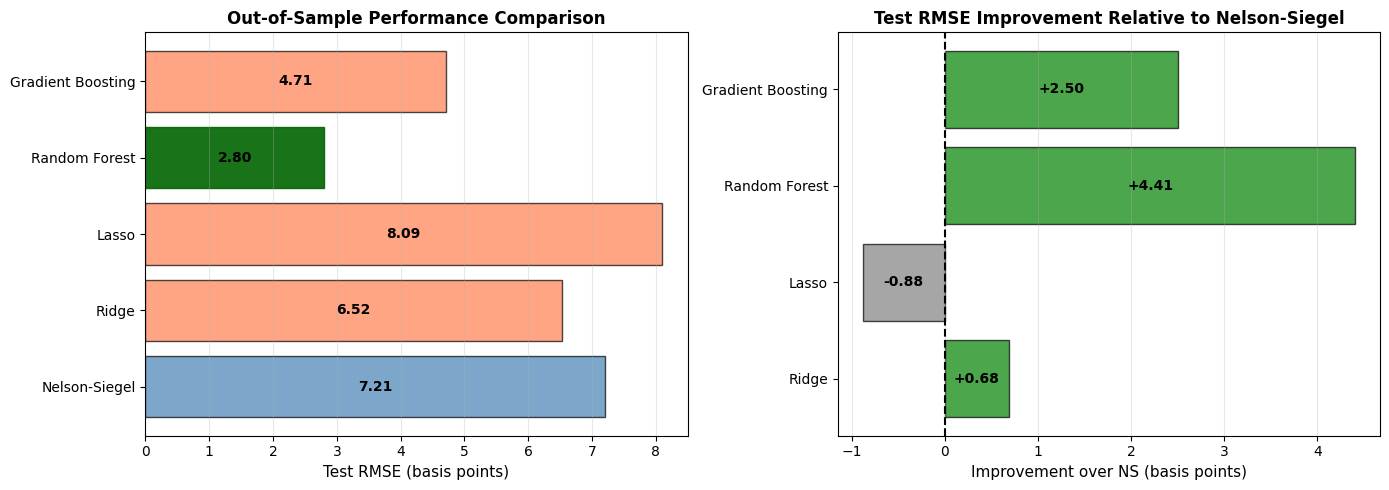

In [27]:
# Calculate improvement metrics
comparison_data = {
    'Method': ['Nelson-Siegel', 'Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'Train RMSE (bps)': [
        ns_train.rmse_bps,
        ridge_result.train_rmse,
        lasso_result.train_rmse,
        rf_result.train_rmse,
        gb_result.train_rmse
    ],
    'Test RMSE (bps)': [
        test_rmse,
        ridge_result.test_rmse,
        lasso_result.test_rmse,
        rf_result.test_rmse,
        gb_result.test_rmse
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Test/Train Ratio'] = comparison_df['Test RMSE (bps)'] / comparison_df['Train RMSE (bps)']
comparison_df['Improvement vs NS (bps)'] = test_rmse - comparison_df['Test RMSE (bps)']
comparison_df['Improvement vs NS (%)'] = ((test_rmse - comparison_df['Test RMSE (bps)']) / test_rmse * 100)

# Identify best method
best_idx = comparison_df['Test RMSE (bps)'].idxmin()
best_method = comparison_df.loc[best_idx, 'Method']
best_rmse = comparison_df.loc[best_idx, 'Test RMSE (bps)']
improvement = comparison_df.loc[best_idx, 'Improvement vs NS (bps)']
improvement_pct = comparison_df.loc[best_idx, 'Improvement vs NS (%)']

# Prepare summary DataFrame for best method
best_summary = pd.DataFrame({
    "Key": [
        "Best out-of-sample method",
        "Test RMSE (bps)",
        "Improvement over NS (bps)",
        "Improvement over NS (%)"
    ],
    "Value": [
        best_method,
        f"{best_rmse:.2f}",
        f"{improvement:.2f}",
        f"{improvement_pct:.1f}%"
    ]
}).set_index("Key")

# Display main performance comparison table
display(comparison_df.style.set_caption(f"Performance Comparison — {one_date.date()}"))

# Display summary of the best method
display(best_summary.style.set_caption("Best Model Summary"))

# Visualize model comparison and RMSE improvements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot: Test RMSE for all methods
methods = comparison_df["Method"]
test_rmse_vals = comparison_df["Test RMSE (bps)"]

bar_colors = ["steelblue" if m == "Nelson-Siegel" else "coral" for m in methods]
bars = ax1.barh(methods, test_rmse_vals, color=bar_colors, edgecolor="black", alpha=0.7)

# Highlight best method
best_bar_idx = test_rmse_vals.idxmin()
bars[best_bar_idx].set_color("darkgreen")
bars[best_bar_idx].set_alpha(0.9)

ax1.set_xlabel("Test RMSE (basis points)", fontsize=11)
ax1.set_title("Out-of-Sample Performance Comparison", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3, axis="x")

# Add value labels centered within the bars
for i, (bar, val) in enumerate(zip(bars, test_rmse_vals)):
    width = bar.get_width()
    ax1.text(
        width / 2, bar.get_y() + bar.get_height() / 2, f"{val:.2f}",
        va="center", ha="center", fontsize=10, color="black", fontweight="bold"
    )

# Bar plot: Improvement over NS, exclude NS baseline itself
ns_mask = comparison_df["Method"] != "Nelson-Siegel"
methods_no_ns = comparison_df.loc[ns_mask, "Method"]
improvement_vals_no_ns = comparison_df.loc[ns_mask, "Improvement vs NS (bps)"]
imp_colors = ["gray" if v <= 0 else "green" for v in improvement_vals_no_ns]

bars2 = ax2.barh(
    methods_no_ns,
    improvement_vals_no_ns,
    color=imp_colors,
    edgecolor="black",
    alpha=0.7,
)
ax2.axvline(0, color="black", linewidth=1.5, linestyle="--")
ax2.set_xlabel("Improvement over NS (basis points)", fontsize=11)
ax2.set_title("Test RMSE Improvement Relative to Nelson-Siegel", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="x")

# Add value labels centered within the bars for the improvement plot - set all to black font
for i, (bar, val) in enumerate(zip(bars2, improvement_vals_no_ns)):
    width = bar.get_width()
    ax2.text(
        width / 2, bar.get_y() + bar.get_height() / 2, f"{val:+.2f}",
        va="center", ha="center", fontsize=10,
        color="black", fontweight="bold"
    )

plt.tight_layout()
plt.show()

### Question 3(c): Multi-date comparison across regimes
Fit all models across multiple dates for representative market regimes

In [28]:
# Define a set of important market dates spanning various economic regimes
regime_dates = {
    "Pre-COVID (2019-08-15)": pd.Timestamp("2019-08-15"),
    "COVID Peak (2020-03-20)": pd.Timestamp("2020-03-20"),
    "Worst NS Test RMSE (2020-08-14)": pd.Timestamp("2020-08-14"),
    "COVID Recovery (2021-06-15)": pd.Timestamp("2021-06-15"),
    "Fed Hiking (2022-09-15)": pd.Timestamp("2022-09-15"),
    "SVB Stress (2023-03-15)": pd.Timestamp("2023-03-15"),
    "Random Date (2024-06-15)": pd.Timestamp("2024-06-15"),
    "Most Recent Date (2025-12-31)": pd.Timestamp("2025-12-31"),
}

multi_date_results = []

# Iterate over each market regime/date specified above
for regime_name, date in regime_dates.items():

    # Find the closest actual available date in the data to the regime date
    available_dates = treasury_panel[PANEL_DATE_COL].unique()
    closest_date = min(available_dates, key=lambda x: abs(x - date))
    # Extract data for that date
    df_date = treasury_panel[treasury_panel[PANEL_DATE_COL] == closest_date].copy()

    # Skip dates with insufficient bond data, ensuring stability for model fitting
    if len(df_date) < 30:
        continue

    # Attempt to perform a stratified train-test split of the bond panel data for that date
    try:
        train_df, test_df = stratified_train_test_split(
            df_date,
            ttm_col=PANEL_TTM_COL,
            test_size=0.2,
            random_state=42,
            n_strata=3,
        )
    except Exception:
        continue

    # Prepare features and targets for both training and test sets
    tau_tr = train_df[PANEL_TTM_COL].to_numpy()
    y_tr = train_df[PANEL_YTM_COL].to_numpy()
    cpn_tr = train_df[PANEL_CPN_COL].to_numpy()
    tau_te = test_df[PANEL_TTM_COL].to_numpy()
    y_te = test_df[PANEL_YTM_COL].to_numpy()
    cpn_te = test_df[PANEL_CPN_COL].to_numpy()

    # Create machine learning features including Nelson-Siegel basis for each sample
    X_tr = create_ml_features(
        tau_tr, cpn=cpn_tr, degree=3, include_ns_features=True
    )
    X_te = create_ml_features(
        tau_te, cpn=cpn_te, degree=3, include_ns_features=True
    )

    # Try fitting the Nelson-Siegel model and reporting its out-of-sample RMSE
    try:
        ns_fit = fit_ns_yields_sse(tau_tr, y_tr)
        y_te_pred_ns = ns_yield(
            tau_te, ns_fit.beta0, ns_fit.beta1, ns_fit.beta2, ns_fit.lam
        )
        ns_test_rmse = rmse_bps(y_te, y_te_pred_ns)
    except Exception:
        # If fitting fails, do not record this regime/date
        continue

    # Collect result for this regime/date, starting with the NS benchmark
    result_row = {
        "regime": regime_name,
        "date": closest_date,
        "n_bonds": len(df_date),
        "NS": ns_test_rmse,
    }

    # Try fitting Ridge regression, add result if successful or np.nan if not
    try:
        ridge_fit = fit_ridge_cv(X_tr, y_tr, X_te, y_te)
        result_row["Ridge"] = ridge_fit.test_rmse
    except Exception:
        result_row["Ridge"] = np.nan

    # Try fitting Lasso regression, add result if successful or np.nan if not
    try:
        lasso_fit = fit_lasso_cv(X_tr, y_tr, X_te, y_te)
        result_row["Lasso"] = lasso_fit.test_rmse
    except Exception:
        result_row["Lasso"] = np.nan

    # Try fitting Random Forest, add result if successful or np.nan if not
    try:
        rf_fit = fit_random_forest_cv(X_tr, y_tr, X_te, y_te)
        result_row["Random Forest"] = rf_fit.test_rmse
    except Exception:
        result_row["Random Forest"] = np.nan

    # Try fitting Gradient Boosting, add result if successful or np.nan if not
    try:
        gb_fit = fit_gradient_boosting_cv(X_tr, y_tr, X_te, y_te)
        result_row["Gradient Boosting"] = gb_fit.test_rmse
    except Exception:
        result_row["Gradient Boosting"] = np.nan

    # Append results for this regime/date to main results list
    multi_date_results.append(result_row)

# Convert results into DataFrame format for further analysis/display
multi_date_df = pd.DataFrame(multi_date_results)

,regime,date,n_bonds,NS,Ridge,Lasso,Random Forest,Gradient Boosting,Winner,Best RMSE
0,Pre-COVID (2019-08-15),2019-08-16,355,5.512945,15.972553,20.933817,2.997764,3.384785,Random Forest,2.997764
1,COVID Peak (2020-03-20),2020-03-20,348,8.710924,7.702107,23.611975,4.800311,4.684085,Gradient Boosting,4.684085
2,Worst NS Test RMSE (2020-08-14),2020-08-14,372,98.328227,96.878390,99.343208,80.156548,72.017209,Gradient Boosting,72.017209
3,COVID Recovery (2021-06-15),2021-06-18,370,5.577778,5.555886,43.238214,3.232237,3.460066,Random Forest,3.232237
4,Fed Hiking (2022-09-15),2022-09-16,377,11.240937,37.088678,39.912401,6.373754,29.686559,Random Forest,6.373754
5,SVB Stress (2023-03-15),2023-03-17,383,18.686236,16.777288,36.332593,6.752250,7.411307,Random Forest,6.752250
6,Random Date (2024-06-15),2024-06-14,394,12.982937,11.499508,39.403023,5.381525,5.949045,Random Forest,5.381525
7,Most Recent Date (2025-12-31),2025-12-31,401,7.207090,6.522317,8.090773,2.799001,4.706853,Random Forest,2.799001


,Winner,Winner Count,Dates Count
0,Random Forest,6,8
1,Gradient Boosting,2,8


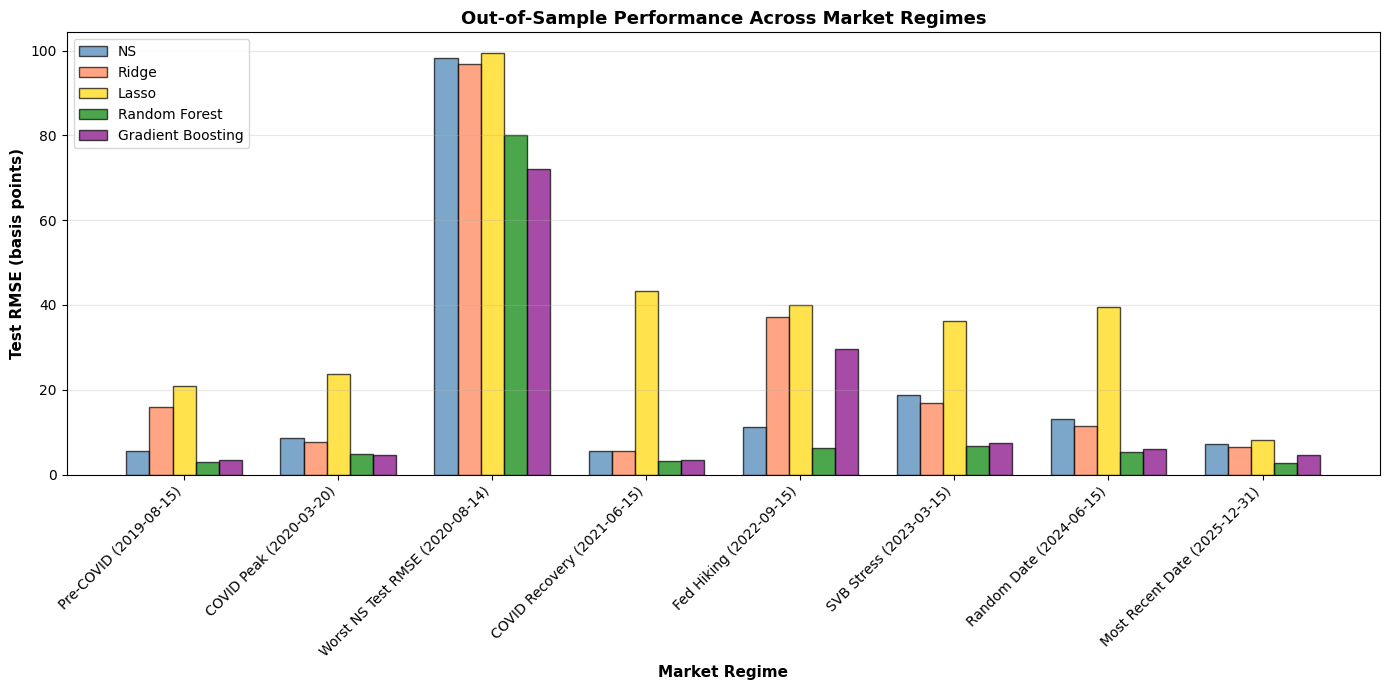

In [29]:
# Display multi-regime performance comparison as a styled DataFrame

display_df = multi_date_df.copy()
display_df["date"] = display_df["date"].dt.date

# Reorder columns for clarity
cols = [
    "regime",
    "date",
    "n_bonds",
    "NS",
    "Ridge",
    "Lasso",
    "Random Forest",
    "Gradient Boosting",
]
display_df = display_df[cols]

# Identify winner and best RMSE for each date
method_cols = [
    "NS",
    "Ridge",
    "Lasso",
    "Random Forest",
    "Gradient Boosting",
]
display_df["Winner"] = display_df[method_cols].idxmin(axis=1)
display_df["Best RMSE"] = display_df[method_cols].min(axis=1)

# Compute winner counts
winner_counts = display_df["Winner"].value_counts().rename("Winner Count")
winner_summary_df = winner_counts.reset_index()
winner_summary_df = winner_summary_df.rename(columns={"index": "Method"})
winner_summary_df["Dates Count"] = f"{len(display_df)}"

# Display the main comparison table with a caption
display(
    display_df.style.set_caption("Multi-Regime Performance Comparison (Test RMSE in bps)")
)

# Display the winner summary table with a caption
display(
    winner_summary_df.style.set_caption("Overall Method Winner Count Across Regimes")
)

# Visualize out-of-sample performance across market regimes
fig, ax = plt.subplots(figsize=(14, 7))

regimes = display_df["regime"].values
x = np.arange(len(regimes))
width = 0.15

methods = ["NS", "Ridge", "Lasso", "Random Forest", "Gradient Boosting"]
colors = {
    "NS": "steelblue",
    "Ridge": "coral",
    "Lasso": "gold",
    "Random Forest": "green",
    "Gradient Boosting": "purple"
}

for idx, method in enumerate(methods):
    offset = (idx - 2) * width
    values = display_df[method].values
    ax.bar(
        x + offset,
        values,
        width,
        label=method,
        color=colors[method],
        edgecolor="black",
        alpha=0.7,
    )

ax.set_xlabel("Market Regime", fontsize=11, fontweight="bold")
ax.set_ylabel("Test RMSE (basis points)", fontsize=11, fontweight="bold")
ax.set_title("Out-of-Sample Performance Across Market Regimes", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(regimes, rotation=45, ha="right")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

### Question 3(d): Identify Best Method and Regime Dependence

**Analysis: Which method performs best and when?**  
**Overall Performance:** Based on a multi-regime analysis of Test RMSE (in bps), we observe the following:

- **Machine Learning methods dominate:** The results show that Random Forest (RF) and Gradient Boosting (GB) consistently outperform both parametric and regularized models across all tested regimes.

- **The "Winner" is relatively consistent:** Random Forest is the most frequent winner, securing the best Test RMSE in 6 out of 8 regimes. Gradient Boosting wins in the remaining 2 regimes, especially during the high-volatility periods ("COVID Peak" and "Worst NS Test RMSE").

- **Nelson-Siegel (NS) vs. ML:** While NS is interpretable, it never wins a single regime out of the 8 tested regimes. Its Test RMSE is often 2x to 4x higher than the tree-based method that wins, except in the most recent stable period (2025-12-31), where the gap is narrower.

- **Lasso is the worst performer:** In nearly every regime, Lasso exhibits the highest Test RMSE, often exceeding 20–40 bps. This suggests its feature selection (zeroing out coefficients) is too aggressive for yield curve modeling.

**Regime-Specific Observations:**

- **Worst NS Case (2020-08-14):** This was the most challenging period for all models. Gradient Boosting performed best here (72.02 bps), beating NS (98.33 bps) by a significant margin. This suggests GB handles extreme "kinks" and volatility better than other methods.

- **COVID Peak (2020-03-20):** Gradient Boosting again leads (4.68 bps), while NS struggles more (8.71 bps).

- **Stable/Recent Periods (2024–2025):** Random Forest is the clear winner in calmer markets, achieving a very low RMSE of 2.80 bps on the most recent date (2025-12-31). NS performs respectably here (7.21 bps) but still lags behind ensemble methods.

- **Fed Hiking & SVB Stress (2022–2023):** Random Forest provides the most robust out-of-sample predictions during these period, maintaining errors between 6.37 and 6.75 bps, while NS errors climb to 11–18 bps.

## Question 4: Maturity Segment Analysis
Investigate where ML methods add value.

### Question 4(a): Define maturity segments

In [ ]:
def segment_by_maturity(df: pd.DataFrame, ttm_col: str) -> pd.DataFrame:
    """
    Segment bonds into short/medium/long maturity buckets.

    Segments:
    - Short: τ < 2 years
    - Medium: 2 ≤ τ ≤ 10 years  
    - Long: τ > 10 years

    Parameters:
    -----------
    df : DataFrame
        Bond data with maturity column
    ttm_col : str
        Column name for time to maturity

    Returns:
    --------
    df : DataFrame
        Original dataframe with added 'maturity_segment' column
    """
    df = df.copy()

    conditions = [
        df[ttm_col] < 2,
        (df[ttm_col] >= 2) & (df[ttm_col] <= 10),
        df[ttm_col] > 10
    ]

    choices = ['Short (< 2y)', 'Medium (2-10y)', 'Long (> 10y)']

    df['maturity_segment'] = np.select(conditions, choices, default='Unknown')

    return df

# Apply segmentation to test set
test_cs_segmented = segment_by_maturity(test_cs, PANEL_TTM_COL)

# Create a DataFrame for bond count by segment
segment_counts = test_cs_segmented['maturity_segment'].value_counts().sort_index()
segment_pct = 100 * segment_counts / len(test_cs_segmented)
segment_count_df = (
    pd.DataFrame({
        "Maturity Segment": segment_counts.index, 
        "Bond Count": segment_counts.values, 
        "Percentage": segment_pct.map("{:5.1f}%".format).values
    })
    .set_index("Maturity Segment")
)
segment_count_df = segment_count_df.style.set_caption(f"Test set segmentation for {one_date.date()}: Bond count by segment")

# Display bond count by segment
display(segment_count_df)

# Create and display yield statistics by segment as a DataFrame with caption
segment_stats = (
    test_cs_segmented
    .groupby('maturity_segment')[PANEL_YTM_COL]
    .describe()[['mean', 'std', 'min', 'max']]
)
segment_stats = segment_stats.style.set_caption("Yield statistics by segment")
display(segment_stats)

,Bond Count,Percentage
Maturity Segment,,
Long (> 10y),17,21.5%
Medium (2-10y),30,38.0%
Short (< 2y),32,40.5%


,mean,std,min,max
maturity_segment,,,,
Long (> 10y),0.047284,0.002283,0.042112,0.049573
Medium (2-10y),0.036892,0.001719,0.034837,0.040616
Short (< 2y),0.035032,0.000971,0.031340,0.037679


### Question 4(b): Calculate segment-specific RMSE for NS and best ML method
Compute segment-specific predictions and RMSE for NS and best ML method

In [ ]:
# Prepare test arrays
tau_test_all = test_cs_segmented[PANEL_TTM_COL].to_numpy()
y_test_all = test_cs_segmented[PANEL_YTM_COL].to_numpy()
cpn_test_all = test_cs_segmented[PANEL_CPN_COL].to_numpy()

# Nelson-Siegel predictions
y_test_pred_ns = ns_yield(
    tau_test_all,
    ns_train.beta0,
    ns_train.beta1,
    ns_train.beta2,
    ns_train.lam,
)

# Machine learning features
X_test_all = create_ml_features(
    tau_test_all, cpn=cpn_test_all, degree=3, include_ns_features=True
)

# Predict yields with ML models
y_test_pred_ridge = ridge_result.model.predict(X_test_all)
y_test_pred_rf = rf_result.model.predict(X_test_all)

# Augment test dataframe with predictions and residuals
test_cs_segmented = test_cs_segmented.copy()
test_cs_segmented["y_true"] = y_test_all
test_cs_segmented["y_pred_ns"] = y_test_pred_ns
test_cs_segmented["y_pred_ridge"] = y_test_pred_ridge
test_cs_segmented["y_pred_rf"] = y_test_pred_rf
test_cs_segmented["resid_ns"] = y_test_all - y_test_pred_ns
test_cs_segmented["resid_ridge"] = y_test_all - y_test_pred_ridge
test_cs_segmented["resid_rf"] = y_test_all - y_test_pred_rf

def segment_rmse_analysis(df: pd.DataFrame, methods: list[str]) -> pd.DataFrame:
    """
    Calculate RMSE by maturity segment for given methods.
    """
    segments = ['Short (< 2y)', 'Medium (2-10y)', 'Long (> 10y)']
    results = []
    for segment in segments:
        segment_df = df[df["maturity_segment"] == segment]
        if segment_df.empty:
            continue
        row = {
            "Segment": segment,
            "N Bonds": len(segment_df),
        }
        y_true = segment_df["y_true"].values
        for method in methods:
            y_pred = segment_df[f"y_pred_{method}"].values
            row[f"{method.upper()} RMSE (bps)"] = rmse_bps(y_true, y_pred)
        results.append(row)
    return pd.DataFrame(results)

methods_to_compare = ["ns", "rf"]
segment_rmse_df = segment_rmse_analysis(test_cs_segmented, methods_to_compare)

# Also calculate the RMSE on all segments combined for each method (i.e., whole test set)
overall_rmse_results = []
n_bonds_all = len(test_cs_segmented)
row = {"Segment": "All (combined)", "N Bonds": n_bonds_all}
for method in methods_to_compare:
    y_pred_all = test_cs_segmented[f"y_pred_{method}"].values
    row[f"{method.upper()} RMSE (bps)"] = rmse_bps(test_cs_segmented["y_true"].values, y_pred_all)
overall_rmse_results.append(row)
overall_rmse_df = pd.DataFrame(overall_rmse_results)

# Display segment-specific RMSE table
segment_rmse_df_styled = segment_rmse_df.style.set_caption(
    f"Segment-specific RMSE (bps) on test set — {one_date.date()}"
)
display(segment_rmse_df_styled)

# Display combined RMSE for all segments
overall_rmse_df_styled = overall_rmse_df.style.set_caption(
    f"Global RMSE (bps) on test set (all segments combined) — {one_date.date()}"
)
display(overall_rmse_df_styled)

,Segment,N Bonds,NS RMSE (bps),RF RMSE (bps)
0,Short (< 2y),32,9.844508,4.213014
1,Medium (2-10y),30,1.305917,0.953690
2,Long (> 10y),17,7.479413,1.179452


,Segment,N Bonds,NS RMSE (bps),RF RMSE (bps)
0,All (combined),79,7.207090,2.799001


### Question 4(c): Create visualization showing performance gap by segment


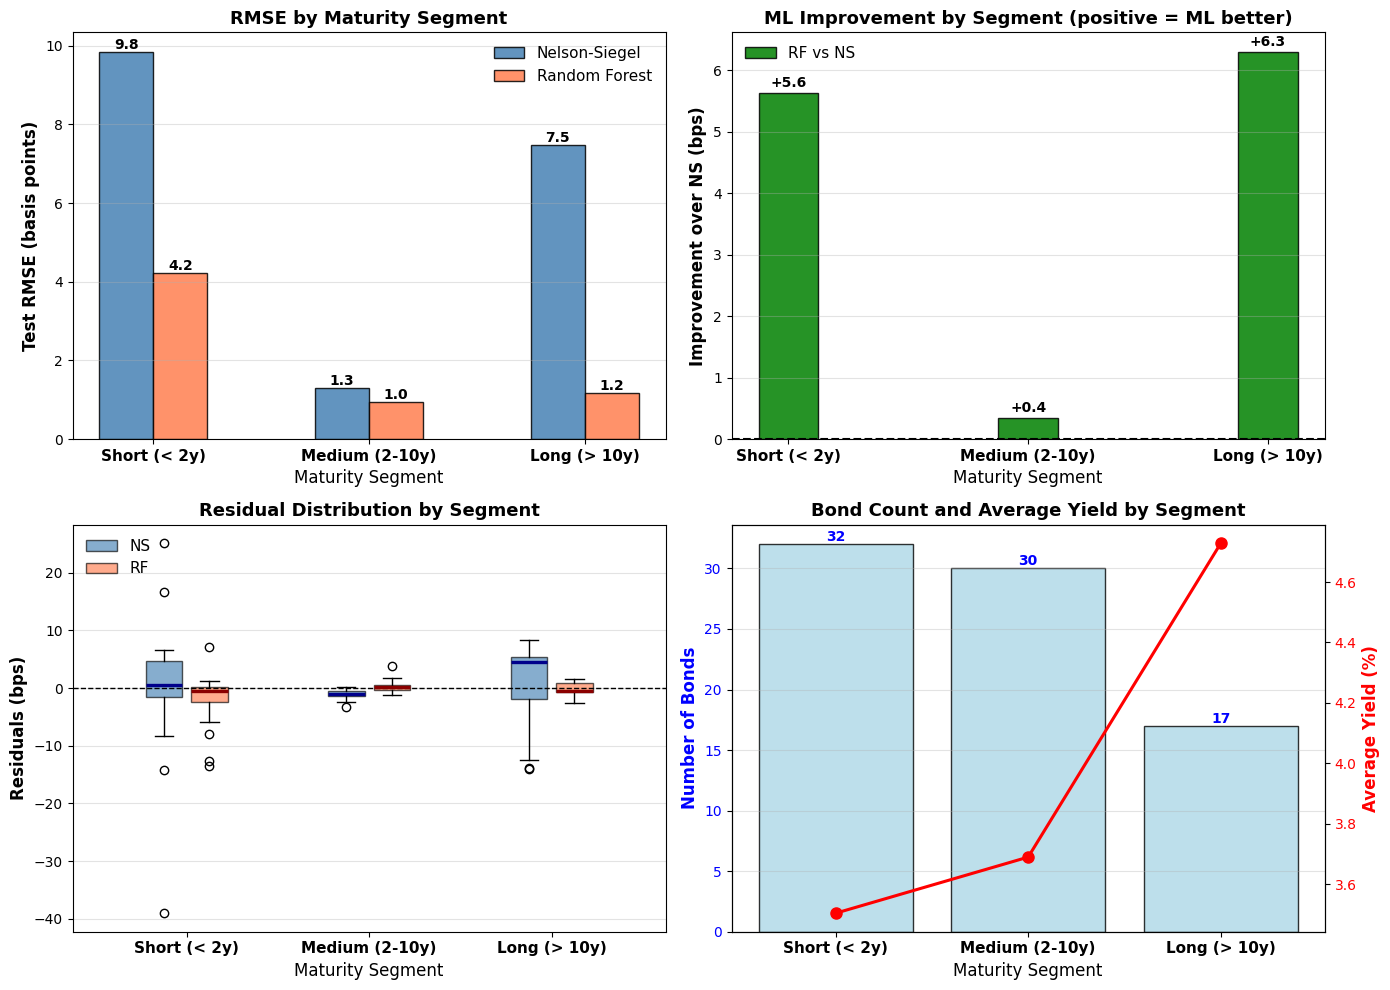

,Bond Count,Maturity Range (yrs),Avg Maturity (yrs),Avg Yield (%),Yield Std Dev (%),NS RMSE (bps),RF RMSE (bps),RF Improvement (bps),RF Improvement (%),Best Model
Segment,,,,,,,,,,
Short (< 2y),32,0.04 - 1.91,0.72,3.503,0.097,9.84,4.21,+5.63,+57.2,RF
Medium (2-10y),30,2.08 - 8.37,4.40,3.689,0.172,1.31,0.95,+0.35,+27.0,RF
Long (> 10y),17,11.37 - 28.37,18.72,4.728,0.228,7.48,1.18,+6.30,+84.2,RF


In [60]:
# Compare NS vs RF: Calculate improvements and plot results

NS_COL = "NS RMSE (bps)"
RF_COL = "RF RMSE (bps)"

if NS_COL not in segment_rmse_df.columns or RF_COL not in segment_rmse_df.columns:
    raise KeyError(
        f"Expected columns '{NS_COL}' and '{RF_COL}' in RMSE dataframe; got {segment_rmse_df.columns}"
    )

segment_rmse_df["RF Improvement"] = segment_rmse_df[NS_COL] - segment_rmse_df[RF_COL]

rf_global_rmse = overall_rmse_df[RF_COL].iloc[0]
ns_global_rmse = overall_rmse_df[NS_COL].iloc[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# === PANEL 1: RMSE by segment ===
ax = axes[0, 0]
segments = segment_rmse_df["Segment"].values
x = np.arange(len(segments))
width = 0.25

bars_ns = ax.bar(
    x - width / 2,
    segment_rmse_df[NS_COL],
    width,
    label="Nelson-Siegel",
    color="steelblue",
    edgecolor="black",
    alpha=0.85,
)
bars_rf = ax.bar(
    x + width / 2,
    segment_rmse_df[RF_COL],
    width,
    label="Random Forest",
    color="coral",
    edgecolor="black",
    alpha=0.85,
)

ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Test RMSE (basis points)", fontsize=12, fontweight="bold")
ax.set_title("RMSE by Maturity Segment", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend(fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# Value labels in bold
for bars in [bars_ns, bars_rf]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="black"
        )

# === PANEL 2: RF improvement ===
ax = axes[0, 1]
improvements_rf = segment_rmse_df["RF Improvement"].values

bars_imp = ax.bar(
    x,
    improvements_rf,
    width,
    label="RF vs NS",
    color=["green" if val > 0 else "red" for val in improvements_rf],
    edgecolor="black",
    alpha=0.85,
)
ax.axhline(0, color="black", linewidth=1.5, linestyle="--")
ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Improvement over NS (bps)", fontsize=12, fontweight="bold")
ax.set_title("ML Improvement by Segment (positive = ML better)", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend(fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# Adjusted: value labels directly above the bar, with very small margin
for bar in bars_imp:
    height = bar.get_height()
    # Choose margin based direction, but much smaller offset
    label_y = height + (0.04 if height > 0 else -0.04)
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        label_y,
        f"{height:+.1f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=10,
        fontweight="bold"
    )

# === PANEL 3: Residual distributions by segment ===
ax = axes[1, 0]
segment_order = ["Short (< 2y)", "Medium (2-10y)", "Long (> 10y)"]
residual_data_ns = [
    test_cs_segmented[test_cs_segmented["maturity_segment"] == seg]["resid_ns"].values * 1e4
    for seg in segment_order
]
residual_data_rf = [
    test_cs_segmented[test_cs_segmented["maturity_segment"] == seg]["resid_rf"].values * 1e4
    for seg in segment_order
]

bp_ns = ax.boxplot(
    residual_data_ns,
    positions=x - width / 2,
    widths=width * 0.8,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="steelblue", alpha=0.65),
    medianprops=dict(color="darkblue", linewidth=2.4),
)
bp_rf = ax.boxplot(
    residual_data_rf,
    positions=x + width / 2,
    widths=width * 0.8,
    patch_artist=True,
    showfliers=True,
    boxprops=dict(facecolor="coral", alpha=0.65),
    medianprops=dict(color="darkred", linewidth=2.4),
)
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_xlabel("Maturity Segment", fontsize=12)
ax.set_ylabel("Residuals (bps)", fontsize=12, fontweight="bold")
ax.set_title("Residual Distribution by Segment", fontsize=13, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax.legend([bp_ns["boxes"][0], bp_rf["boxes"][0]], ["NS", "RF"], loc="upper left", fontsize=11, frameon=False)
ax.grid(True, alpha=0.35, axis="y")

# === PANEL 4: Sample counts and average TTM by segment ===
ax = axes[1, 1]
segment_stats = []
for segment in segment_order:
    seg_df = test_cs_segmented[test_cs_segmented["maturity_segment"] == segment]
    segment_stats.append(
        {
            "segment": segment,
            "count": len(seg_df),
            "avg_ttm": seg_df[PANEL_TTM_COL].mean(),
            "avg_yield": seg_df["y_true"].mean() * 100,
        }
    )
stats_df = pd.DataFrame(segment_stats)

ax_counts = ax
ax_yields = ax.twinx()
bars_count = ax_counts.bar(
    x,
    stats_df["count"],
    color="lightblue",
    edgecolor="black",
    alpha=0.8,
    label="Bond Count",
)
ax_counts.set_xlabel("Maturity Segment", fontsize=12)
ax_counts.set_ylabel("Number of Bonds", fontsize=12, fontweight="bold", color="blue")
ax_counts.set_title("Bond Count and Average Yield by Segment", fontsize=13, fontweight="bold")
ax_counts.set_xticks(x)
ax_counts.set_xticklabels(segments, fontsize=11, fontweight="bold")
ax_counts.tick_params(axis="y", labelcolor="blue")
ax_counts.yaxis.label.set_color("blue")
ax_counts.grid(True, alpha=0.35, axis="y")

line_yield = ax_yields.plot(
    x, stats_df["avg_yield"], "o-", linewidth=2.2, markersize=8, color="red", label="Avg Yield"
)
ax_yields.set_ylabel("Average Yield (%)", fontsize=12, fontweight="bold", color="red")
ax_yields.tick_params(axis="y", labelcolor="red")

for bar, count in zip(bars_count, stats_df["count"]):
    ax_counts.text(
        bar.get_x() + bar.get_width() / 2.0,
        count,
        f"{count}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="blue"
    )

plt.tight_layout()
plt.show()

# Create a DataFrame to summarize segment statistics and model comparisons
segment_summary = []

for segment in segment_order:
    seg_df = test_cs_segmented[test_cs_segmented['maturity_segment'] == segment]
    if seg_df.empty:
        continue

    # Compute statistics
    n_bonds = len(seg_df)
    min_maturity = seg_df[PANEL_TTM_COL].min()
    max_maturity = seg_df[PANEL_TTM_COL].max()
    avg_maturity = seg_df[PANEL_TTM_COL].mean()
    avg_yield = seg_df['y_true'].mean() * 100
    yield_std = seg_df['y_true'].std() * 100

    ns_rmse = rmse_bps(seg_df['y_true'], seg_df['y_pred_ns'])

    # By notebook context & instructions, compare NS and RF (Random Forest)
    if 'y_pred_rf' in seg_df.columns:
        rf_rmse = rmse_bps(seg_df['y_true'], seg_df['y_pred_rf'])
    else:
        rf_rmse = float('nan')

    # Calculate improvements
    rf_improvement = ns_rmse - rf_rmse if not pd.isna(rf_rmse) else float('nan')
    rf_imp_pct = (rf_improvement / ns_rmse * 100) if ns_rmse and not pd.isna(rf_improvement) else float('nan')

    # Determine which model is best
    rmses = {"NS": ns_rmse}
    if not pd.isna(rf_rmse):
        rmses["RF"] = rf_rmse
    best_method = min(rmses, key=rmses.get)

    # Append data for this segment
    segment_summary.append({
        "Segment": segment,
        "Bond Count": n_bonds,
        "Maturity Range (yrs)": f"{min_maturity:.2f} - {max_maturity:.2f}",
        "Avg Maturity (yrs)": f"{avg_maturity:.2f}",
        "Avg Yield (%)": f"{avg_yield:.3f}",
        "Yield Std Dev (%)": f"{yield_std:.3f}",
        "NS RMSE (bps)": f"{ns_rmse:.2f}",
        "RF RMSE (bps)": f"{rf_rmse:.2f}" if not pd.isna(rf_rmse) else "N/A",
        "RF Improvement (bps)": f"{rf_improvement:+.2f}" if not pd.isna(rf_improvement) else "N/A",
        "RF Improvement (%)": f"{rf_imp_pct:+.1f}" if not pd.isna(rf_imp_pct) else "N/A",
        "Best Model": best_method
    })

seg_stats_df = pd.DataFrame(segment_summary)
seg_stats_df = seg_stats_df.set_index("Segment")

seg_stats_df.style.set_caption("Detailed Segment Analysis: NS vs RF Model Performance")

### Question 4(d): Possible Explaination for the observed pattern


#### Explanation of Segment-Specific Performance

Our reaults reveal that Machine Learning (Random Forest, RF) provides substantial value-add over the Nelson-Siegel (NS) model across all segments. However, the magnitude of improvement depends on data density and the limitations of the NS functional form.

#### 1. Data Availability and ML Advantage

- **Short Maturity (< 2 years):**
  - **Data Density:** Highest bond count (32 bonds)
  - **ML Improvement:** +5.63 bps (57.2% improvement)
  - **Insight:** Despite the highest data density, the improvement is secondary to the long end. The high standard deviation in NS residuals for this segment (14.75 bps) suggests that, while there is plenty of data, it is highly "noisy" due to idiosyncratic pricing. RF is able to better capture this noise than the smooth NS curve.

- **Medium Maturity (2–10 years):**
  - **Data Density:** High bond count (30 bonds)
  - **ML Improvement:** +0.35 bps (27.0% improvement)
  - **Insight:** This is the segment where NS performs best. With an NS RMSE of only 1.31 bps, the yield curve is naturally smooth. As a result, RF has the least "room" to improve, since the parametric NS form already captures the "belly" very accurately.

- **Long Maturity (> 10 years):**
  - **Data Density:** Lowest bond count (17 bonds)
  - **ML Improvement:** Largest (+6.30 bps, 84.2% improvement)
  - **Insight:** Contrary to our expectations, RF excels where data is most sparse. This suggests that the NS $\beta_0$ parameter fails to capture the specific "droop" or "kink" at the end of the 2025-12-31 curve, which RF is able to identify even with fewer observations.

#### 2. NS Functional Form Suitability

- The Nelson-Siegel model assumes a smooth, single-humped transition to a long-term level.

  - **Where NS Excels:** In our data, NS is most effective in the Medium segment (2–10Y), achieving a very low RMSE of 1.31 bps. Market yields here follow the smooth, monotonic shape that the NS curvature parameter ($\beta_2$) is designed to describe.
  
  - **Where NS Struggles:**
    - **Ultra-Long End:** The massive improvement by RF (84.2%) for long maturities indicates that the 30-year area has a localized shape (flattening or drop) that the rigid NS level parameter ($\beta_0$) tends to over-predict.
    - **Short-End Kinks:** The high error in the 0–2Y segment (9.84 bps) indicates that NS cannot accommodate the rapid yield changes at the very front of the curve.

#### 3. Systematic Patterns Captured by Machine Learning

- **On-the-Run vs. Off-the-Run Effects:** Residual plots show significant "scattering" in the Short segment. Random Forest likely captures the liquidity premium of on-the-run bills, which trade at lower yields than surrounding off-the-run bonds—something the NS model cannot exploit.

- **Localized Yield Anomalies:** The "wave" pattern seen in the residuals (Positive $\rightarrow$ Negative $\rightarrow$ Positive $\rightarrow$ Negative) suggests the market has multiple inflection points. RF, being tree-based, can adapt to these "kinks" at specific maturities, while NS is forced to average them out to maintain a global smoothness.

## Question 5: Financial Sanity Checks
Verify that fitted curves are economically sensible.

### Question 5(a): Compute yields, discount factors, and forward rates
